In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.utils.data_utils import Sequence

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

Using TensorFlow backend.


In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

In [8]:
daug_train = ImageDataGenerator(horizontal_flip=True, rescale=1/255)
daug_val = ImageDataGenerator(rescale=1/255)

In [14]:
class MultiBranchGenerator(Sequence):
    def __init__(self, x, y, datagen, batch_size=32, steps_per_epoch=100, seed=42):
        datagen.fit(x)
        self.datagen = datagen.flow(x, y, batch_size=min(batch_size, x.shape[0]), seed=seed)
        self.steps_per_epoch = steps_per_epoch
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.datagen.next()
        return x_batch, {"decoded": x_batch, "outputs": y_batch}

In [15]:
train_gen = MultiBranchGenerator(x_train, y_train, daug_train, seed=RANDOM_SEED)
val_gen = MultiBranchGenerator(x_val, y_val, daug_val, steps_per_epoch=20, seed=RANDOM_SEED)

# Model Training 

In [11]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate)(prev_input)
    out = Dense(units, activation=activation)(prev_input)
    return out

In [12]:
# mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
# mlflow.log_param("test_size", TEST_SIZE)
# mlflow.log_param("seed", RANDOM_SEED)
# mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
encode = conv_bn(5, pool_4, 256, activation='tanh', name='encoded')

dec_4 = deconv_bn(4, encode, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_2)

model = Model(inputs=inputs, outputs=[decoded, classif])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 39s 389ms/step - loss: 0.5422 - decoded_loss: 0.0224 - outputs_loss: 0.4974 - outputs_accuracy: 0.7641 - outputs_precision: 0.8312 - outputs_recall: 0.8840 - outputs_f1: 0.8548 - outputs_fbeta: 0.8690 - outputs_specificity: 0.2880 - outputs_negative_predictive_value: 0.4318 - outputs_matthews_correlation_coefficient: 0.2116 - val_loss: 0.7696 - val_decoded_loss: 0.1257 - val_outputs_loss: 0.5326 - val_outputs_accuracy: 0.7664 - val_outputs_precision: 0.7954 - val_outputs_recall: 0.9418 - val_outputs_f1: 0.8624 - val_outputs_fbeta: 0.9054 - val_outputs_specificity: 0.1073 - val_outputs_negative_predictive_value: 0.3351 - val_outputs_matthews_correlation_coefficient: 0.0800

Epoch 00001: val_outputs_fbeta improved from -inf to 0.90538, saving model to ../../models/unsupervised_supervised/multilearner_2021_10_16-20_59_09.h5
Epoch 2/100
100/100 [==============================] - 35s 349ms


Epoch 00010: val_outputs_fbeta did not improve from 0.94749
Epoch 11/100
100/100 [==============================] - 33s 334ms/step - loss: 0.3396 - decoded_loss: 0.0064 - outputs_loss: 0.3268 - outputs_accuracy: 0.8549 - outputs_precision: 0.8750 - outputs_recall: 0.9554 - outputs_f1: 0.9133 - outputs_fbeta: 0.9357 - outputs_specificity: 0.4521 - outputs_negative_predictive_value: 0.7159 - outputs_matthews_correlation_coefficient: 0.4899 - val_loss: 0.3479 - val_decoded_loss: 0.0101 - val_outputs_loss: 0.3164 - val_outputs_accuracy: 0.8816 - val_outputs_precision: 0.8841 - val_outputs_recall: 0.9778 - val_outputs_f1: 0.9285 - val_outputs_fbeta: 0.9554 - val_outputs_specificity: 0.5220 - val_outputs_negative_predictive_value: 0.8671 - val_outputs_matthews_correlation_coefficient: 0.6112

Epoch 00011: val_outputs_fbeta improved from 0.94749 to 0.95540, saving model to ../../models/unsupervised_supervised/multilearner_2021_10_16-20_59_09.h5
Epoch 12/100
100/100 [=========================


Epoch 00020: val_outputs_fbeta did not improve from 0.96268
Epoch 21/100
100/100 [==============================] - 32s 322ms/step - loss: 0.2862 - decoded_loss: 0.0051 - outputs_loss: 0.2761 - outputs_accuracy: 0.8801 - outputs_precision: 0.8956 - outputs_recall: 0.9624 - outputs_f1: 0.9277 - outputs_fbeta: 0.9460 - outputs_specificity: 0.5508 - outputs_negative_predictive_value: 0.7834 - outputs_matthews_correlation_coefficient: 0.5898 - val_loss: 0.2855 - val_decoded_loss: 0.0074 - val_outputs_loss: 0.2681 - val_outputs_accuracy: 0.8973 - val_outputs_precision: 0.9300 - val_outputs_recall: 0.9350 - val_outputs_f1: 0.9323 - val_outputs_fbeta: 0.9322 - val_outputs_specificity: 0.7321 - val_outputs_negative_predictive_value: 0.7530 - val_outputs_matthews_correlation_coefficient: 0.6746

Epoch 00021: val_outputs_fbeta did not improve from 0.96268
Epoch 22/100
100/100 [==============================] - 33s 334ms/step - loss: 0.2871 - decoded_loss: 0.0051 - outputs_loss: 0.2770 - outputs

100/100 [==============================] - 33s 332ms/step - loss: 0.2671 - decoded_loss: 0.0048 - outputs_loss: 0.2574 - outputs_accuracy: 0.8896 - outputs_precision: 0.9030 - outputs_recall: 0.9653 - outputs_f1: 0.9330 - outputs_fbeta: 0.9501 - outputs_specificity: 0.5908 - outputs_negative_predictive_value: 0.8108 - outputs_matthews_correlation_coefficient: 0.6297 - val_loss: 0.2312 - val_decoded_loss: 0.0059 - val_outputs_loss: 0.1944 - val_outputs_accuracy: 0.9246 - val_outputs_precision: 0.9382 - val_outputs_recall: 0.9693 - val_outputs_f1: 0.9534 - val_outputs_fbeta: 0.9625 - val_outputs_specificity: 0.7615 - val_outputs_negative_predictive_value: 0.8696 - val_outputs_matthews_correlation_coefficient: 0.7681

Epoch 00031: val_outputs_fbeta did not improve from 0.96268
Epoch 32/100
100/100 [==============================] - 33s 329ms/step - loss: 0.2692 - decoded_loss: 0.0045 - outputs_loss: 0.2602 - outputs_accuracy: 0.8882 - outputs_precision: 0.9016 - outputs_recall: 0.9651 - o

100/100 [==============================] - 33s 329ms/step - loss: 0.2471 - decoded_loss: 0.0043 - outputs_loss: 0.2385 - outputs_accuracy: 0.8984 - outputs_precision: 0.9125 - outputs_recall: 0.9656 - outputs_f1: 0.9382 - outputs_fbeta: 0.9524 - outputs_specificity: 0.6322 - outputs_negative_predictive_value: 0.8205 - outputs_matthews_correlation_coefficient: 0.6615 - val_loss: 0.2363 - val_decoded_loss: 0.0081 - val_outputs_loss: 0.2632 - val_outputs_accuracy: 0.9041 - val_outputs_precision: 0.9041 - val_outputs_recall: 0.9814 - val_outputs_f1: 0.9410 - val_outputs_fbeta: 0.9632 - val_outputs_specificity: 0.6099 - val_outputs_negative_predictive_value: 0.8984 - val_outputs_matthews_correlation_coefficient: 0.6879

Epoch 00041: val_outputs_fbeta improved from 0.96268 to 0.96317, saving model to ../../models/unsupervised_supervised/multilearner_2021_10_16-20_59_09.h5
Epoch 42/100
100/100 [==============================] - 34s 336ms/step - loss: 0.2501 - decoded_loss: 0.0044 - outputs_lo

100/100 [==============================] - 33s 332ms/step - loss: 0.2352 - decoded_loss: 0.0042 - outputs_loss: 0.2267 - outputs_accuracy: 0.9049 - outputs_precision: 0.9179 - outputs_recall: 0.9675 - outputs_f1: 0.9420 - outputs_fbeta: 0.9549 - outputs_specificity: 0.6565 - outputs_negative_predictive_value: 0.8345 - outputs_matthews_correlation_coefficient: 0.6849 - val_loss: 0.1987 - val_decoded_loss: 0.0047 - val_outputs_loss: 0.2357 - val_outputs_accuracy: 0.9162 - val_outputs_precision: 0.9276 - val_outputs_recall: 0.9636 - val_outputs_f1: 0.9452 - val_outputs_fbeta: 0.9553 - val_outputs_specificity: 0.7217 - val_outputs_negative_predictive_value: 0.8423 - val_outputs_matthews_correlation_coefficient: 0.7262

Epoch 00051: val_outputs_fbeta did not improve from 0.96831
Epoch 52/100
100/100 [==============================] - 33s 332ms/step - loss: 0.2373 - decoded_loss: 0.0041 - outputs_loss: 0.2292 - outputs_accuracy: 0.9026 - outputs_precision: 0.9155 - outputs_recall: 0.9673 - o

100/100 [==============================] - 33s 333ms/step - loss: 0.2221 - decoded_loss: 0.0040 - outputs_loss: 0.2141 - outputs_accuracy: 0.9107 - outputs_precision: 0.9231 - outputs_recall: 0.9690 - outputs_f1: 0.9454 - outputs_fbeta: 0.9574 - outputs_specificity: 0.6795 - outputs_negative_predictive_value: 0.8454 - outputs_matthews_correlation_coefficient: 0.7057 - val_loss: 0.2434 - val_decoded_loss: 0.0047 - val_outputs_loss: 0.3229 - val_outputs_accuracy: 0.8900 - val_outputs_precision: 0.9566 - val_outputs_recall: 0.9011 - val_outputs_f1: 0.9279 - val_outputs_fbeta: 0.9089 - val_outputs_specificity: 0.8522 - val_outputs_negative_predictive_value: 0.7036 - val_outputs_matthews_correlation_coefficient: 0.7051

Epoch 00061: val_outputs_fbeta did not improve from 0.96870
Epoch 62/100
100/100 [==============================] - 33s 329ms/step - loss: 0.2228 - decoded_loss: 0.0040 - outputs_loss: 0.2149 - outputs_accuracy: 0.9100 - outputs_precision: 0.9227 - outputs_recall: 0.9689 - o

100/100 [==============================] - 33s 328ms/step - loss: 0.2126 - decoded_loss: 0.0038 - outputs_loss: 0.2050 - outputs_accuracy: 0.9158 - outputs_precision: 0.9279 - outputs_recall: 0.9700 - outputs_f1: 0.9484 - outputs_fbeta: 0.9592 - outputs_specificity: 0.6998 - outputs_negative_predictive_value: 0.8534 - outputs_matthews_correlation_coefficient: 0.7231 - val_loss: 0.2257 - val_decoded_loss: 0.0052 - val_outputs_loss: 0.2191 - val_outputs_accuracy: 0.9201 - val_outputs_precision: 0.9275 - val_outputs_recall: 0.9763 - val_outputs_f1: 0.9512 - val_outputs_fbeta: 0.9648 - val_outputs_specificity: 0.7171 - val_outputs_negative_predictive_value: 0.8896 - val_outputs_matthews_correlation_coefficient: 0.7524

Epoch 00071: val_outputs_fbeta did not improve from 0.96870
Epoch 72/100
100/100 [==============================] - 33s 328ms/step - loss: 0.2115 - decoded_loss: 0.0038 - outputs_loss: 0.2038 - outputs_accuracy: 0.9152 - outputs_precision: 0.9276 - outputs_recall: 0.9696 - o

100/100 [==============================] - 33s 328ms/step - loss: 0.2050 - decoded_loss: 0.0037 - outputs_loss: 0.1976 - outputs_accuracy: 0.9170 - outputs_precision: 0.9291 - outputs_recall: 0.9701 - outputs_f1: 0.9491 - outputs_fbeta: 0.9596 - outputs_specificity: 0.7054 - outputs_negative_predictive_value: 0.8543 - outputs_matthews_correlation_coefficient: 0.7272 - val_loss: 0.1877 - val_decoded_loss: 0.0053 - val_outputs_loss: 0.2059 - val_outputs_accuracy: 0.9202 - val_outputs_precision: 0.9496 - val_outputs_recall: 0.9516 - val_outputs_f1: 0.9506 - val_outputs_fbeta: 0.9494 - val_outputs_specificity: 0.8022 - val_outputs_negative_predictive_value: 0.8072 - val_outputs_matthews_correlation_coefficient: 0.7551

Epoch 00081: val_outputs_fbeta did not improve from 0.97078
Epoch 82/100
100/100 [==============================] - 33s 328ms/step - loss: 0.2028 - decoded_loss: 0.0036 - outputs_loss: 0.1955 - outputs_accuracy: 0.9190 - outputs_precision: 0.9308 - outputs_recall: 0.9709 - o

100/100 [==============================] - 33s 328ms/step - loss: 0.1980 - decoded_loss: 0.0035 - outputs_loss: 0.1909 - outputs_accuracy: 0.9212 - outputs_precision: 0.9333 - outputs_recall: 0.9707 - outputs_f1: 0.9515 - outputs_fbeta: 0.9610 - outputs_specificity: 0.7252 - outputs_negative_predictive_value: 0.8603 - outputs_matthews_correlation_coefficient: 0.7429 - val_loss: 0.2736 - val_decoded_loss: 0.0067 - val_outputs_loss: 0.3044 - val_outputs_accuracy: 0.9011 - val_outputs_precision: 0.9482 - val_outputs_recall: 0.9243 - val_outputs_f1: 0.9360 - val_outputs_fbeta: 0.9265 - val_outputs_specificity: 0.8115 - val_outputs_negative_predictive_value: 0.7434 - val_outputs_matthews_correlation_coefficient: 0.7132

Epoch 00091: val_outputs_fbeta did not improve from 0.97078
Epoch 92/100
100/100 [==============================] - 33s 328ms/step - loss: 0.1950 - decoded_loss: 0.0036 - outputs_loss: 0.1879 - outputs_accuracy: 0.9224 - outputs_precision: 0.9339 - outputs_recall: 0.9715 - o

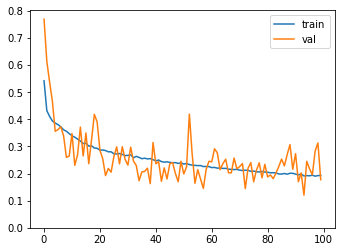

In [16]:
DECODED_LOSS_WEIGHT = 2.0
OUTPUTS_LOSS_WEIGHT = 1.0

# mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
# mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_fbeta"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_gen,
    validation_steps=20,
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

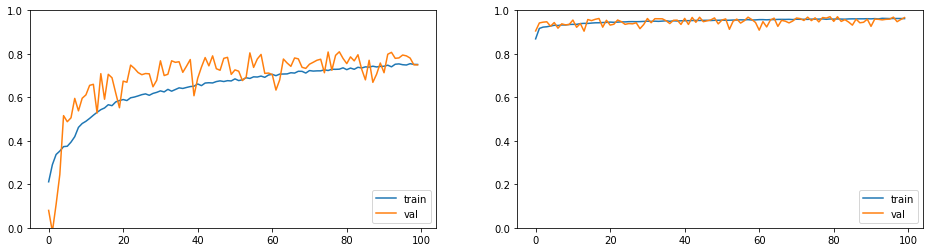

In [17]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1]
[1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1]


Text(0.5, 1.0, 'decoded image')

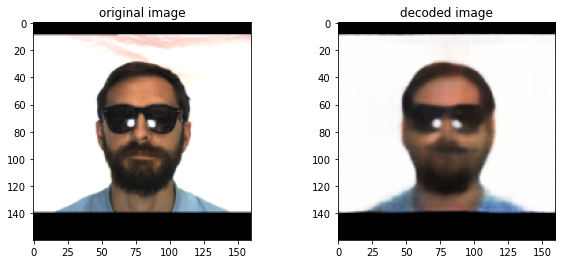

In [20]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0) / 255
y_true = y_val[random_idx] 

y_pred_decoded, y_pred_outputs = model.predict(im)
y_pred_outputs = np.where(y_pred_outputs > 0.5, 1, 0)

print(y_true, y_pred_outputs[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [21]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(inputs=model.inputs, outputs=model.get_layer('outputs').output, name="ICAOnet")
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2021_10_16-20_59_09.h5
Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
___________________________________________________________

In [22]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)[1]
y_pred_clf = model_clf.predict(im)
assert(np.allclose(y_pred_ori, y_pred_clf))

for y_pred in y_pred_clf[0]:
    print(y_pred)

../../data/cropped_faces/images/AR_FDB_m-013-17.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



0.96584404
0.6930988
0.9911039
0.8343758
0.9982884
0.9917187
0.8100195
0.82856894
0.63486695
0.44740623
0.8163537
0.93933976
0.6298286
0.95359755
0.9433017
0.9968586
0.62309843
0.99961996
0.9082571
0.9999232
0.99478936
0.3001573
0.99753845


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [23]:
mlflow.end_run()